In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import adtk
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, QuantileAD, InterQuartileRangeAD, PersistAD, LevelShiftAD, VolatilityShiftAD
from IPython.display import display
from ydata_profiling import ProfileReport

In [ ]:
# data_dir_heater = "../data/smart_home/office_heater.csv"
# data_dir_theromostat = "../data/smart_home/office_thermostat.csv"

# df_heater = pd.read_csv(
#     data_dir_heater,
#     delimiter=",",
#     header=0,
#     parse_dates=True,
# )

# df_thermostat = pd.read_csv(
#     data_dir_theromostat,
#     delimiter=",",
#     header=0,
#     parse_dates=True,
# )

##### Daten säubern

In [ ]:
# unique_heater_sensor_state = df_heater["state"].unique()
# unique_thermostat_sensor_state = df_thermostat["state"].unique()

# # print(unique_heater_sensor_state)
# # print(unique_thermostat_sensor_state)

# unwanted_heater_sensor_state = ["unavailable", "unknown"]
# unwanted_thermostat_sensor_state = ["unavailable"]

# df_heater_temp = df_heater
# df_thermostat_temp = df_thermostat

# df_heater_temp = df_heater_temp[~df_heater_temp["state"].isin(unwanted_heater_sensor_state)]
# df_thermostat_temp = df_thermostat_temp[~df_thermostat_temp["state"].isin(unwanted_thermostat_sensor_state)]

# # Sortiere die Daten nach Datum und Uhrzeit
# df_heater_temp = df_heater_temp.sort_values(by="datetime")
# df_thermostat_temp = df_thermostat_temp.sort_values(by="datetime")

# df_heater_temp.to_csv("../data/smart_home/office_heater_clean.csv", index=False)
# df_thermostat_temp.to_csv("../data/smart_home/office_thermostat_clean.csv", index=False)

#### Nutze gesäuberten Datensatz

In [93]:
# Workaround: Datensatz mit Benennung vertauschen. Heizung mit Temperature Sensor wurde bei dem Code vertauscht und ist erst
# später aufgefallen. Keine Lust alle Variablen umzubenennen.
data_dir_heater = "../data/smart_home/office_thermostat_clean.csv"
data_dir_theromostat = "../data/smart_home/office_heater_clean.csv"

df_heater = pd.read_csv(
    data_dir_heater,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_thermostat = pd.read_csv(
    data_dir_theromostat,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_heater["datetime"] = pd.to_datetime(df_heater["datetime"], format="ISO8601", errors="coerce")
df_thermostat["datetime"] = pd.to_datetime(df_thermostat["datetime"], format="ISO8601", errors="coerce")

print(df_heater.info())
# df_heater.dtypes

print(df_thermostat.info())
# df_thermostat.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   entity_id            664 non-null    object             
 1   state                664 non-null    object             
 2   datetime             664 non-null    datetime64[ns, UTC]
 3   current_temperature  664 non-null    float64            
 4   hvac_action          0 non-null      float64            
 5   target_temp_high     0 non-null      float64            
 6   target_temp_low      0 non-null      float64            
 7   temperature          664 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(2)
memory usage: 41.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  ----- 

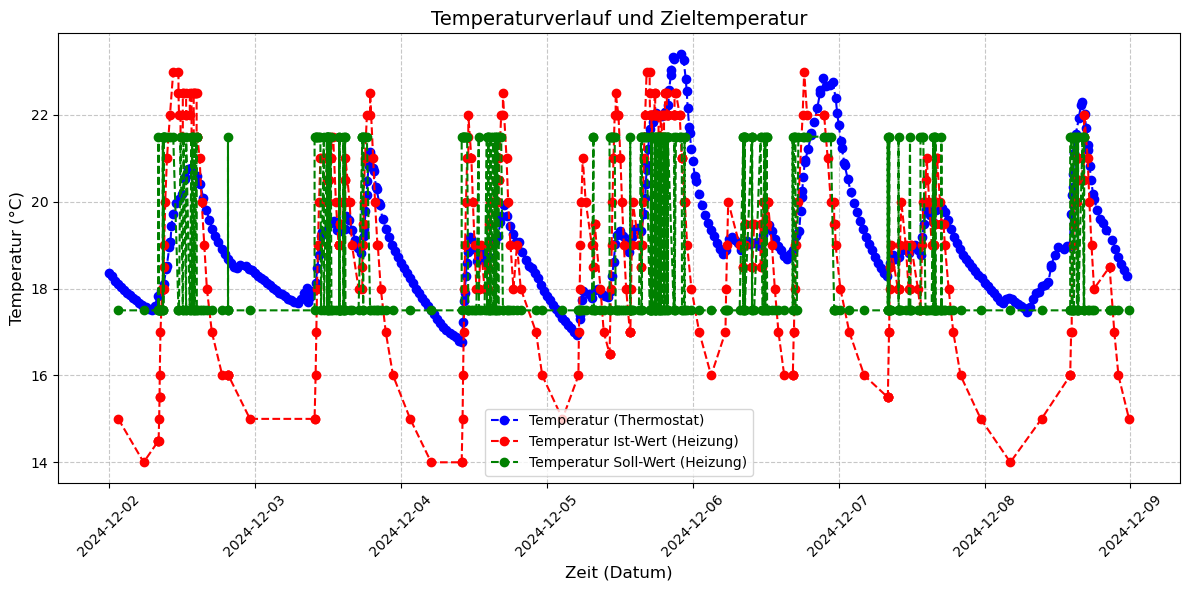

In [94]:
# Define the date and time ranges
start_time = "2024-12-02 00:00:00"
end_time = "2024-12-08 23:59:59"

# Filtern der Daten nach dem angegebenen Zeitraum
df_heater_filtered = df_heater.copy()
df_thermostat_filtered = df_thermostat.copy()

# Filter anwenden
df_heater_filtered = df_heater_filtered[
    (df_heater_filtered["datetime"] >= start_time) & (df_heater_filtered["datetime"] <= end_time)
]

df_thermostat_filtered = df_thermostat_filtered[
    (df_thermostat_filtered["datetime"] >= start_time) & (df_thermostat_filtered["datetime"] <= end_time)
]

# Plot erstellen
plt.figure(figsize=(12, 6))

# Temperatur-Daten (Thermostat) plotten
plt.plot(
    df_thermostat_filtered["datetime"],
    df_thermostat_filtered["state"],
    marker="o",
    linestyle="--",
    color="blue",
    label="Temperatur (Thermostat)",
)

# Temperatur-Daten (Heizung) plotten
plt.plot(
    df_heater_filtered["datetime"],
    df_heater_filtered["current_temperature"],
    marker="o",
    linestyle="--",
    color="red",
    label="Temperatur Ist-Wert (Heizung)",
)

# Temperatur-Daten (Heizung) plotten
plt.plot(
    df_heater_filtered["datetime"],
    df_heater_filtered["temperature"],
    marker="o",
    linestyle="--",
    color="green",
    label="Temperatur Soll-Wert (Heizung)",
)

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel("Zeit (Datum)", fontsize=12)
plt.ylabel("Temperatur (°C)", fontsize=12)
plt.title(f"Temperaturverlauf und Zieltemperatur", fontsize=14)  # für den {start_time.split(' ')[0]}

# Extract unique time points for x-axis
# time_points = df_thermostat_filtered["datetime"].apply(lambda t: t.strftime("%H:%M:%S.") + t.strftime("%f")[:2]).tolist()

# Achsenformat anpassen
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Diagramm anzeigen
plt.tight_layout()
plt.show()

##### Automatische Anomalieerkennung
- QuantileAD: Abweichungen gefunden. Diese sind jedoch minimal und sollte nicht als "echter" Fehler eingestuft werden
- InterQuartileRangeAD: Keine Anomalie erkannt -> Regelung erfüllt ihren Zweck für diesen Zeitraum ohne Fehler

In [95]:
df_heater_ad = df_heater_filtered.copy()

df_heater_ad = df_heater_ad[["datetime", "current_temperature"]]
df_heater_ad.loc[:, "datetime"] = pd.to_datetime(df_heater_ad["datetime"])
df_heater_ad.set_index("datetime", inplace=True)  # Set 'datetime' as the index
df_heater_ad = validate_series(df_heater_ad)

[<Axes: >]

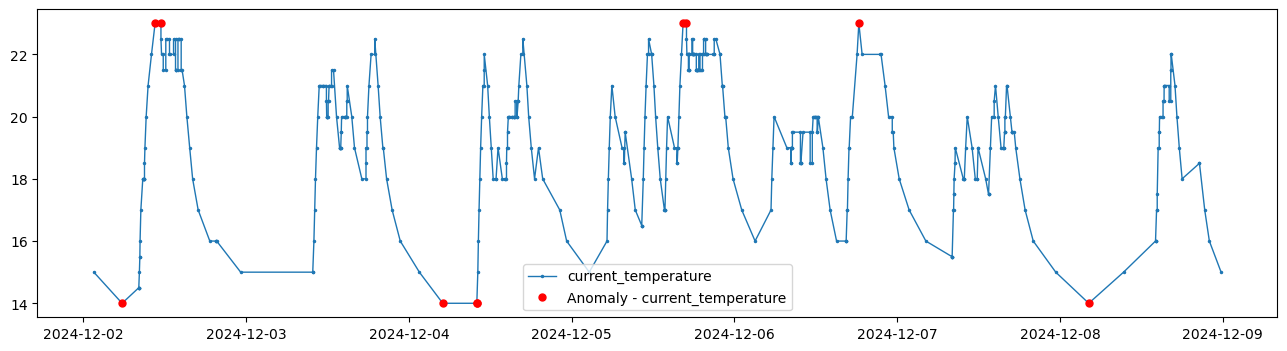

In [ ]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df_heater_ad)

plot(
    df_heater_ad,
    anomaly=anomalies,
    ts_linewidth=1,
    ts_markersize=3,
    anomaly_markersize=5,
    anomaly_color="red",
    anomaly_tag="marker",
)

[<Axes: >]

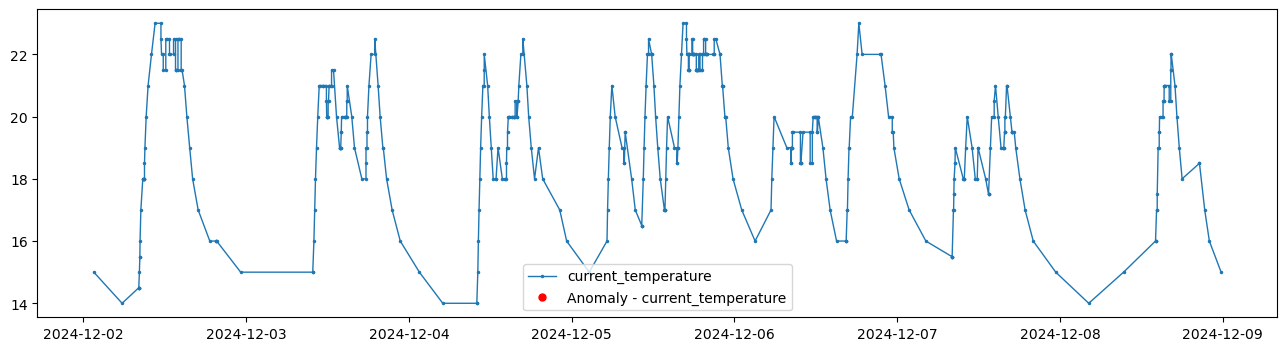

In [97]:
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(df_heater_ad)

plot(
    df_heater_ad,
    anomaly=anomalies,
    ts_linewidth=1,
    ts_markersize=3,
    anomaly_markersize=5,
    anomaly_color="red",
    anomaly_tag="marker",
)